In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

counts = pd.read_csv('/home/gridsan/djuna/homer/github/ABCA7lof2/bulkRNAseq/featureCounts/counts.txt', delimiter='\t', comment="#")
# load metadata
metadata = pd.read_csv('/home/gridsan/djuna/homer/github/ABCA7lof2/bulkRNAseq/abca7_rna_seq_metadata_with_seqIDs.csv')
metadata['SeqID'] = metadata['SeqID'].str.strip()



/state/partition1/slurm_tmp/27660540.0.0/ipykernel_692320/4042896635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='gene_type', data=gene_type_counts, palette='viridis')


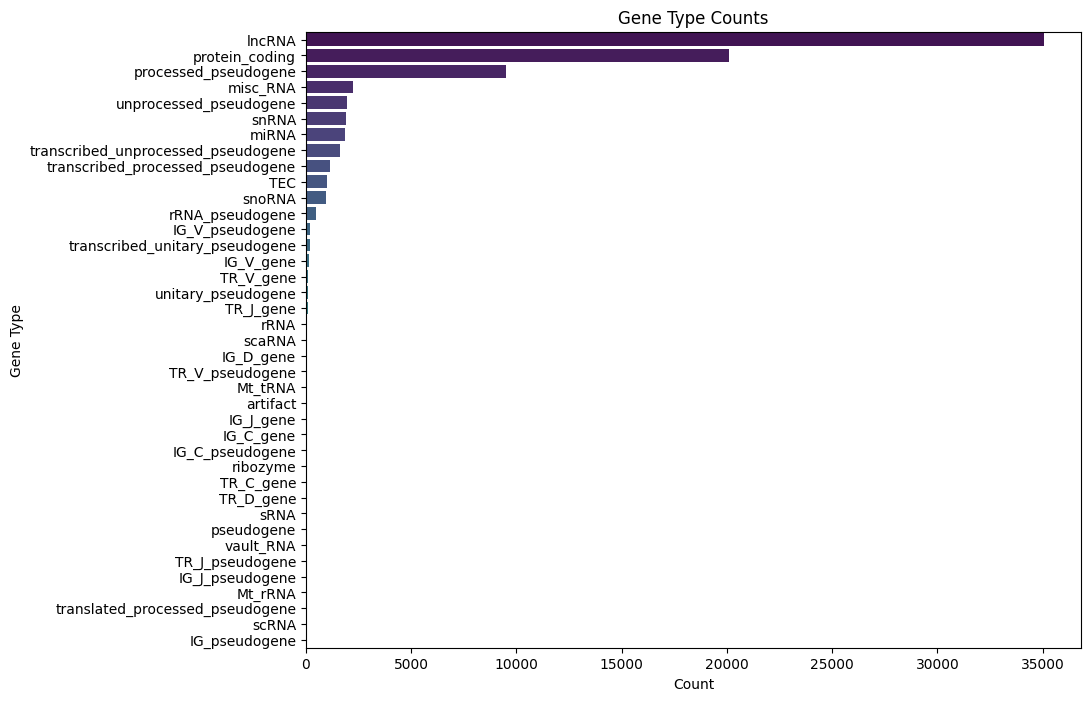

In [4]:
# show the number of genes of each type
gene_type_counts = counts['gene_type'].value_counts().reset_index()
gene_type_counts.columns = ['gene_type', 'count']

plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='gene_type', data=gene_type_counts, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Gene Type')
plt.title('Gene Type Counts')
plt.show()

In [6]:
# get counts
sam_columns = [col for col in counts.columns if col.endswith('.sam')]
counts_extracted = counts[sam_columns]
new_column_names = {col: col.split('_')[1].split('Aligned')[0] for col in counts_extracted.columns}
counts_extracted.rename(columns=new_column_names, inplace=True)
counts_sums = counts_extracted.sum(axis=0)
counts_cpm = counts_extracted.div(counts_sums, axis=1) * 1e6 # what library size should I be using? only the aligned reads?


names = set(counts['gene_name'][counts['gene_type']=='protein_coding'])

index = counts['gene_type']=='protein_coding'
counts_cpm_protein_coding = counts_cpm[index]
counts_cpm_protein_coding.index = counts['gene_name'][index]
counts_cpm_protein_coding = counts_cpm_protein_coding.iloc[:, 1:]


/state/partition1/slurm_tmp/27660540.0.0/ipykernel_692320/1671742046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_extracted.rename(columns=new_column_names, inplace=True)


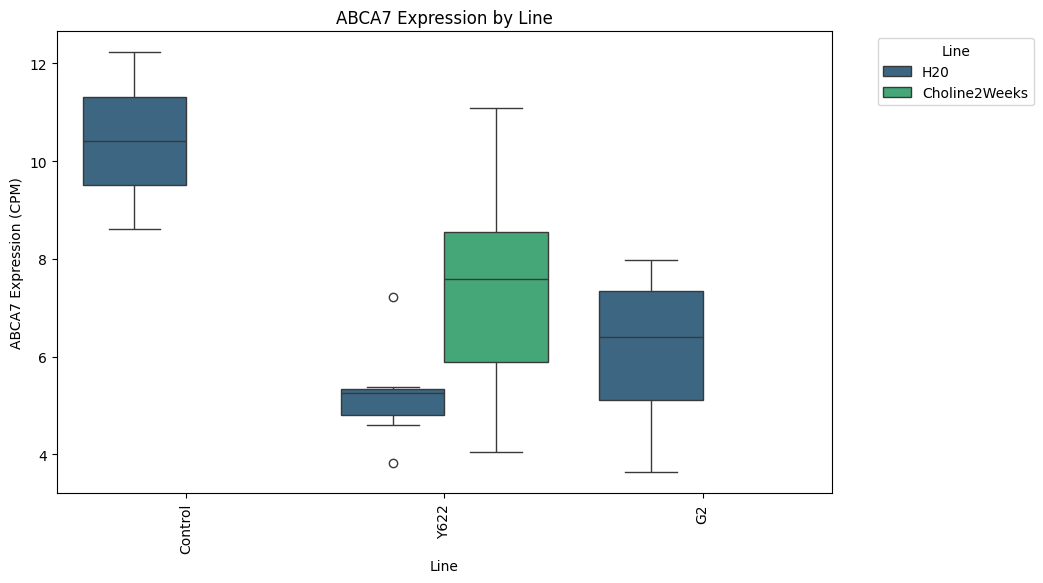

In [7]:
# show the expression of ABCA7
abca7_data = pd.DataFrame(counts_cpm_protein_coding.loc['ABCA7'])
abca7_data['SeqID'] = abca7_data.index
abca7_data = pd.merge(abca7_data, metadata[['SeqID', 'Line', 'Treatment']], on='SeqID')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Line', y='ABCA7', data=abca7_data, hue='Treatment', palette='viridis')
plt.xlabel('Line')
plt.ylabel('ABCA7 Expression (CPM)')
plt.title('ABCA7 Expression by Line')
plt.xticks(rotation=90)
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


(16, 20116)

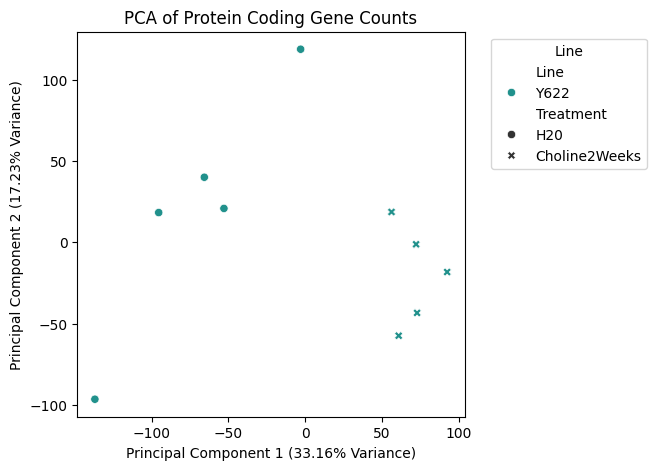

In [43]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line'] == 'Y622']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(batch_1_seqids, line_seqids)]


# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns

pca_df = pd.merge(pca_df, metadata, on='SeqID')

plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



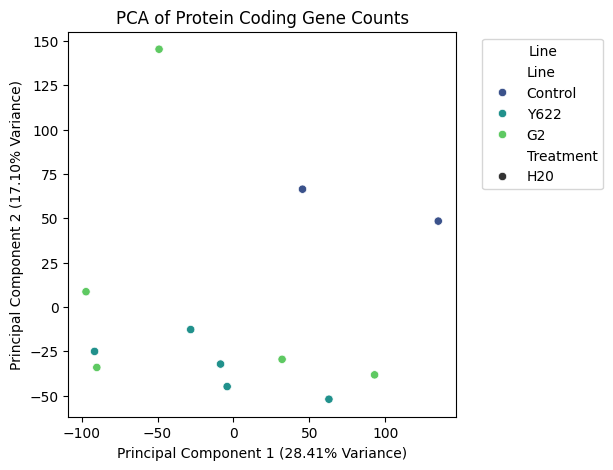

In [46]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(batch_1_seqids, line_seqids)]


# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns

pca_df = pd.merge(pca_df, metadata, on='SeqID')

plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [52]:
treatment_seqids

0     D24-18553
1     D24-18554
2     D24-18555
3     D24-18556
4     D24-18557
5     D24-18558
6     D24-18559
7     D24-18560
8     D24-18561
9     D24-18562
18    D24-18571
19    D24-18572
20    D24-18574
21    D24-18575
22    D24-18576
23    D24-18577
24    D24-18578
25    D24-18580
Name: SeqID, dtype: object

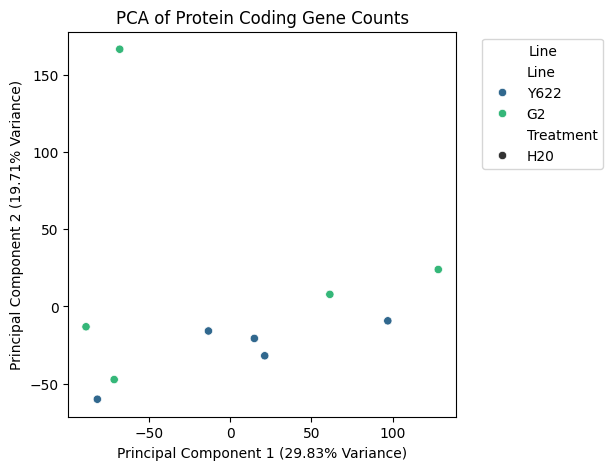

In [54]:
# show PCA; treatment batch 1
batch_1_seqids = metadata[metadata['Notes'].str.contains('batch 1')]['SeqID']
line_seqids = metadata[metadata['Line']!= 'Control']['SeqID']
treatment_seqids = metadata[metadata['Treatment'] == 'H20']['SeqID']
counts_cpm_protein_coding_batch_1 = counts_cpm_protein_coding[np.intersect1d(np.intersect1d(batch_1_seqids, line_seqids), (treatment_seqids))]


# Perform PCA on the counts_cpm_protein_coding
scaler = StandardScaler()
counts_cpm_protein_coding_scaled = scaler.fit_transform(counts_cpm_protein_coding_batch_1.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(counts_cpm_protein_coding_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['SeqID'] = counts_cpm_protein_coding_batch_1.columns

pca_df = pd.merge(pca_df, metadata, on='SeqID')

plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')

# Calculate the explained variance for each principal component
explained_variance = pca.explained_variance_ratio_

plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% Variance)')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



,PC1,PC2,SeqID,SampleName,Line,Treatment,Vol (ul),Conc,Type,Pool,Genome,Notes
0,-12.617582,-25.462987,D24-18553,E1,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
1,-86.513930,-42.836915,D24-18554,E2,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
2,54.923952,98.041953,D24-18555,Y1,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
3,22.816851,59.733246,D24-18556,Y2,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
4,-12.979081,63.627358,D24-18557,Y3,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
5,0.452243,58.713614,D24-18558,Y4,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
6,-58.348193,37.010624,D24-18559,Y5,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,..."
7,104.683950,-22.701122,D24-18560,Y6,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)
8,18.786732,-59.519155,D24-18561,Y7,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)
9,42.354146,-58.534927,D24-18562,Y8,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled)


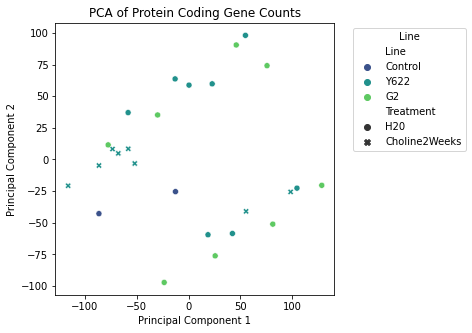

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Line', style='Treatment', data=pca_df, palette='viridis', edgecolor='w')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Protein Coding Gene Counts')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [1]:
metadata

NameError: name 'metadata' is not defined

In [69]:
metadata

,SampleName,Line,Treatment,Vol (ul),Conc,Type,Pool,Genome,Notes,SeqID
SeqID,,,,,,,,,,
D24-18553,E1,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18553
D24-18554,E2,Control,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18554
D24-18555,Y1,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18555
D24-18556,Y2,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18556
D24-18557,Y3,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18557
D24-18558,Y4,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18558
D24-18559,Y5,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,"diff & extraction batch 1 (1 well, DOI:101624,...",D24-18559
D24-18560,Y6,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled),D24-18560
D24-18561,Y7,Y622,H20,30,2-10 ng/ul,totalRNA,NaN,human,diff & extraction batch 2 (2 wells pooled),D24-18561


In [60]:
x = counts_cpm_protein_coding.mean(axis=1).sort_values(ascending=False).index

In [62]:
np.where(x=='ABCA7')

(array([9398]),)